In [14]:
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from PIL import Image, ImageDraw
from torchvision import transforms

from datasets import load_dataset, Dataset, DatasetDict
import evaluate

import torch
from transformers import ViTImageProcessor
from transformers import ViTForImageClassification
from transformers import ViTFeatureExtractor

from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
from transformers import TrainingArguments
from transformers import Trainer

In [2]:
image_folder = Path(r'C:\Users\lzuni\Documents\Tesis\database\patches')
labels_csv = Path(r'C:\Users\lzuni\Documents\Tesis\database\patch_labels.csv')

In [ ]:
from datasets import load_dataset

ds = load_dataset( 'lzunigao/emphysema', token="token")
ds = ds.rename_column("label", "labels")
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 105
    })
    validation: Dataset({
        features: ['image', 'labels'],
        num_rows: 12
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 51
    })
})

In [40]:
ex = ds['train'][40]

image = ex['image']

labels = ds['train'].features['labels']
labels.int2str(ex['labels'])

'2'

Filter: 100%|██████████| 105/105 [00:00<00:00, 1555.71 examples/s]


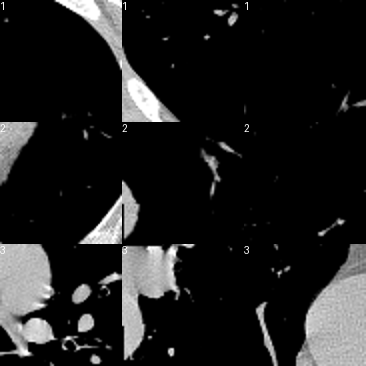

In [41]:
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(122, 122)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255))

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

In [42]:

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)


C:\Users\lzuni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [43]:
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[-1.0000, -1.0000, -1.0000,  ...,  0.4353,  0.4431,  0.4431],
          [-1.0000, -1.0000, -1.0000,  ...,  0.4353,  0.4431,  0.4431],
          [-1.0000, -1.0000, -1.0000,  ...,  0.4510,  0.4588,  0.4588],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ...,  0.4353,  0.4431,  0.4431],
          [-1.0000, -1.0000, -1.0000,  ...,  0.4353,  0.4431,  0.4431],
          [-1.0000, -1.0000, -1.0000,  ...,  0.4510,  0.4588,  0.4588],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ...,  0.4353,  0.4431,  0.4431],
          [-1

In [44]:

def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs


def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }



def compute_metrics(p):
    metric = evaluate.load("accuracy")
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [45]:

prepared_ds = ds.with_transform(transform)
prepared_ds['train'][0:2]


{'pixel_values': tensor([[[[ 0.3804,  0.3804,  0.3804,  ...,  0.9059,  1.0000,  1.0000],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.9059,  1.0000,  1.0000],
          [ 0.4118,  0.4118,  0.4118,  ...,  0.9216,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [ 1.0000,  1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [ 1.0000,  1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[ 0.3804,  0.3804,  0.3804,  ...,  0.9059,  1.0000,  1.0000],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.9059,  1.0000,  1.0000],
          [ 0.4118,  0.4118,  0.4118,  ...,  0.9216,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [ 1.0000,  1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [ 1.0000,  1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[ 0.3804,  0.3804,  0.3804,  ...,  0.9059,  1.0000,  1.0000],
          [ 0

In [47]:
labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels)
    
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
training_args = TrainingArguments(
  output_dir="./vit-base-patches",
  per_device_train_batch_size=4,
  eval_strategy="steps",
  num_train_epochs=1,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=3,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    processing_class=feature_extractor,
)

In [49]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss


***** train metrics *****
  epoch                    =        1.0
  total_flos               =  7577922GF
  train_loss               =     0.9464
  train_runtime            = 0:00:44.74
  train_samples_per_second =      2.347
  train_steps_per_second   =      0.603


In [50]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        1.0
  eval_accuracy           =     0.4167
  eval_loss               =     0.9294
  eval_runtime            = 0:00:02.77
  eval_samples_per_second =      4.319
  eval_steps_per_second   =       0.72


In [61]:
# Load the test image
test_image_path = './my_patch.tiff'
# Use a pipeline as a high-level helper
from transformers import pipeline

# Load the model
model_lz = ViTForImageClassification.from_pretrained('./vit-base-patches')
processor = ViTImageProcessor.from_pretrained(model_name_or_path)
#use pipeline

classifier = pipeline('image-classification', model=model_lz, processor=processor)
classifier(test_image_path)



Exception: Impossible to guess which image processor to use. Please provide a PreTrainedImageProcessor class or a path/identifier to a pretrained image processor.